## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
from collections import Counter
from pymystem3 import Mystem
m = Mystem()

from IPython.display import display

In [2]:
df = pd.read_csv('/datasets/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Таблица выглядит приемлемой, единственное, что бросается в глаза, странные "минусы" и разрядность в столбце 'days_employed'. 
Попробуем проанализировать аномалии в стаже

In [3]:
df.groupby('income_type')['days_employed'].mean()

income_type
безработный        366413.652744
в декрете           -3296.759962
госслужащий         -3399.896902
компаньон           -2111.524398
пенсионер          365003.491245
предприниматель      -520.848083
сотрудник           -2326.499216
студент              -578.751554
Name: days_employed, dtype: float64

Видимо, аномалии в связаны с источником данных для стажа для разных групп клиентов, допускаю, что данные для безработных и пенсионеров берутся из других документов. Данные для остальных групп клиентов выглядят вполне релевантно, только занесены были почему-то с минусом.

Изучим таблицу подробнее

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Обращаем внимание, что типы данных в нужных нам столбцах корректны. В столбцах 'days_employed' и 'total_income' имеются пропущенные значения. Посмотрим, если связь между пропусками в стаже и доходом, очень подозрительно выглядит одинаковое количество пропусков в этих столбцах

In [5]:
df[df['total_income'].isna()]['days_employed'].count()

0

Во всех строках, где пропущен стаж, также пропущены данные о доходе. 
Возможно, кредит этим людям выдали без раскрытия информации о доходах и стаже (отсутствовала или не были занесены данные из  справки с места работы).

Посчитаем существенность пропусков (их долю в общем количестве), чтобы понять, можем ли мы просто удалить строки с пропущенными данными

In [6]:
df.isna().mean()*100

children             0.000000
days_employed       10.099884
dob_years            0.000000
education            0.000000
education_id         0.000000
family_status        0.000000
family_status_id     0.000000
gender               0.000000
income_type          0.000000
debt                 0.000000
total_income        10.099884
purpose              0.000000
dtype: float64

In [7]:
df = df.drop(['days_employed'], axis=1)

Удалим столбец со стажем, так как для анализа он нам далее не пригодится.

### Вывод

1) Типы данных в таблице соотвествуют их содержанию

2) Есть аномалии в заполнении столбца 'days_employed' , столбец можно удалить, для дальнейшего анализа не пригодится

3) Пропуски не можем удалить, будем заполнять, так как:
 - количество пропусков значимо (около 10%) 
 - столбец 'total_income' понадобится для дальнейшего анализа

4) Во всех строках, где пропущен стаж, также пропущены данные о доходе. Возможно, клиенты не раскрывали эту информацию 

5) Странная разрядность в столбце 'total_income', слишком много знаков после запятой, возможно, это вызвано c вычислением среднемесяного дохода

### Шаг 2. Предобработка данных

### Обработка пропусков

Так как количество пропусков в столбце 'total_income' составляет 10%, их удаление может сильно отразиться на результате и последующем выводе. 

Необходимо понять каким образом следует заполнить пропуски - использовать среднюю или медиану ? по каким группировкам заполнять пропуски

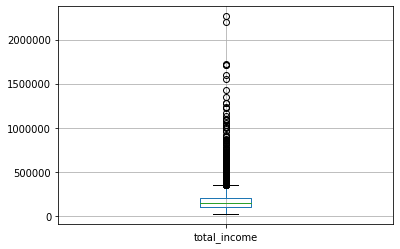

In [8]:
df.boxplot('total_income')

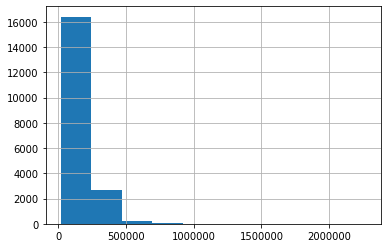

In [9]:
df['total_income'].hist()

На графиках распределения дохода по суммам, видим значительное количество выбросов, что делает выбор в пользу медианы очевидным. (Медиана менее подверждена выбросам)

Далее необходимо понять, следует ли применять медиану для всех клиентов, или сгруппированным по какому либо признаку.

In [10]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

Анализируем клиентов по видам доходов. Дубликатов нет. Можем использовать эти данные для анализа без предварительной обработки.Обращаем внимаение, что кредиты практически не выдают безработным клиентам (что звучит логично).

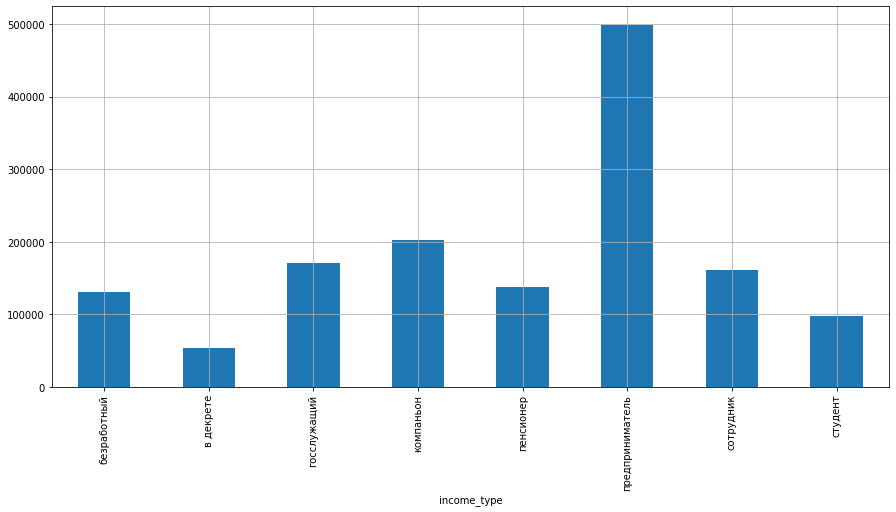

In [11]:
df.groupby('income_type')['total_income'].mean().plot(kind = 'bar',grid = True, figsize = (15,7))

На графике видим заметную зависимость дохода от рода деятельности. 
Первый признак для группировки медианы готов.

Следующим шагом проверим зависимость дохода от образования

In [12]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

При анализе видов видов образования видим множество дубликатов отличающихся регистром. Приведем данные к нижнему регистру.

In [13]:
df['education'] = df['education'].str.lower()
df['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Убедились, что все дубликаты ушли. Кстати, интересный момент - видим, что ученые неохотно пользуются кредитами (видно не просто так - "ученые")

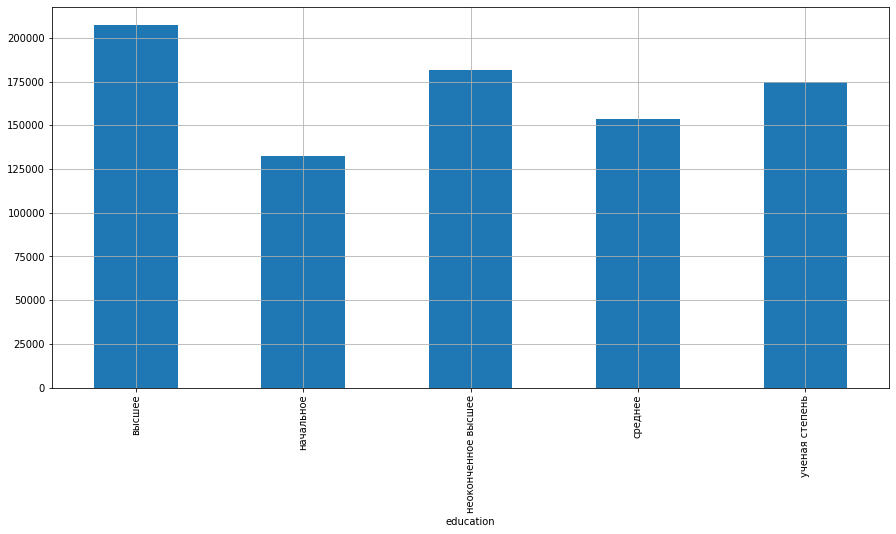

In [14]:
df.groupby('education')['total_income'].mean().plot(kind = 'bar', grid = True, figsize = (15,7))

На графике видим, что зависимость между доходом и образованием - подтвердилась. Далее проверим, можем ли мы применить второе свойство группировки для медианы - образование

In [15]:
df.pivot_table(index = 'education', columns ='income_type', values ='total_income', aggfunc ='mean')

income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
education,,,,,,,,
высшее,202722.511368,NaN,197320.548067,242375.855503,170667.987802,499163.144947,191564.306210,98201.625314
начальное,NaN,NaN,184056.353037,165057.030695,111314.924441,NaN,137212.850187,NaN
неоконченное высшее,NaN,NaN,172476.953367,197649.335647,138312.108423,NaN,174697.072430,NaN
среднее,59956.991984,53829.130729,154055.103706,179490.220250,131698.933496,NaN,152662.997144,NaN
ученая степень,NaN,NaN,111392.231107,NaN,177088.845999,NaN,194310.337215,NaN


Свойство образование - не можем применить для группировки, так как не можем найти для всех строк медиану. Для группировки используем только вид дохода

Свойство пола также не включаем в список свойств группировки

Для заполнения пропусков 'total_income' используем медиану для доходов людей схожих по виду дохода ('income_type')

In [16]:
df['total_income'].fillna(value = df.groupby(['income_type'])['total_income'].transform('median'), inplace = True)

In [17]:
df.isna().mean()*100

children            0.0
dob_years           0.0
education           0.0
education_id        0.0
family_status       0.0
family_status_id    0.0
gender              0.0
income_type         0.0
debt                0.0
total_income        0.0
purpose             0.0
dtype: float64

Проверяем, что все пропуски в столбце 'total_income' заполнены.

### Замена типа данных

In [18]:
df['total_income'] =  df['total_income'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
children            21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(6), object(5)
memory usage: 1.8+ MB


Для удобства преобразовываем тип данных float в Int в столбце 'total_income'

### Обработка дубликатов

Данные еще не готовы для анализа, необходимо найти и обработать дубликаты

In [19]:
df.duplicated().sum()

71

Делаем допущение, что не может быть двух клиентов с асболютно идентичными данными, удаляем дупликаты

In [20]:
df = df.drop_duplicates()
df = df.reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 11 columns):
children            21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null int64
purpose             21454 non-null object
dtypes: int64(6), object(5)
memory usage: 1.8+ MB


Проверяем, что дубликаты удалены.

### Вывод

Скорее всего дупликаты появились в результате сбоя записи или выгрузки данных. Следовало бы обратиться к ответственным за выгрузку и уточнить возможную причину появления дупликатов. Для анализа дупликаты удаляем

### Лемматизация

Для дальнейшего анализа влияния целей кредита на возврат кредита. Необходимо категоризировать цели с помощью лемматизации

План действий:
- определим частоиспользуемые слова для целей кредита (столбец 'purpose')
- создадим словарь целей кредита на основе анализа частоты испольщования
- создадим столбец, в котором разобьем цель кредита на отдельные слова приведенные к их лемме
- циклом проверим каждую лемму на совпадение со словарем, если совпадение есть, вернем лемму.
- проверим для всех ли строк будут найдены леммы

In [21]:
purposes_list = []

for purposes in df['purpose'].unique():
    for word in purposes.split():
        lemmas = ' '.join(m.lemmatize(word))
        purposes_list.append(lemmas)
              
Counter(purposes_list)

Counter({'покупка \n': 10,
         'жилье \n': 7,
         'приобретение \n': 1,
         'автомобиль \n': 9,
         'дополнительный \n': 2,
         'образование \n': 9,
         'сыграть \n': 1,
         'свадьба \n': 3,
         'операция \n': 4,
         'с \n': 5,
         'на \n': 4,
         'проведение \n': 1,
         'для \n': 2,
         'семья \n': 1,
         'недвижимость \n': 10,
         'коммерческий \n': 2,
         'жилой \n': 2,
         'строительство \n': 3,
         'собственный \n': 1,
         'подержать \n': 2,
         'свой \n': 4,
         'со \n': 1,
         'заниматься \n': 2,
         'сделка \n': 2,
         'получение \n': 3,
         'высокий \n': 3,
         'профильный \n': 1,
         'сдача \n': 1,
         'ремонт \n': 1})

Выводим список всех уникальных слов в полях "цель кредита" приведенных к лемме и частоту их использования

In [22]:
purposes_list = ['автомобиль','образование','свадьба','недвижимость','жилье'] 

Создали словарь целей на основе частоты использования слов в цели кредита.

In [23]:
df['lemmas'] = df['purpose'].apply(m.lemmatize)    

Создали новый столбец, в котором привели все слова в поле "цель кредита" к их леммам

In [24]:
def extract_purpose(text):
    for word in purposes_list:
        if word in text:
            return word
         
df['purpose_cat'] = df['lemmas'].apply(extract_purpose)

Сверяем каждую лемму из целей кредита со словарем целей. Возвращаем совпадения.

In [25]:
df.loc[df['purpose_cat'] == 'жилье', 'purpose_cat'] = 'недвижимость'

Так как по смыслу категории жилье и недвижимость идентичны - объеденяем их в одну категорию.

In [26]:
df['purpose_cat'].value_counts()

недвижимость    10811
автомобиль       4306
образование      4013
свадьба          2324
Name: purpose_cat, dtype: int64

Проверяем, для всех ли строк была найдена лемма их словаря целей. Пустых значений нет, все удалось.

In [27]:
df['purpose_cat'].value_counts() / df['purpose_cat'].count()*100

недвижимость    50.391535
автомобиль      20.070849
образование     18.705137
свадьба         10.832479
Name: purpose_cat, dtype: float64

Обращаем внимание на долю каждой категории в общем количестве выданных кредитов.


### Вывод

Все цели, на которые люди берут кредиты можно разбить на 4 категории:

- недвижимость 
- автомобиль    
- образование        
- свадьба

высокая доля кредитов на операции с недвижимостью (половина всех сделок) скорее всего связана с тем, что банки активнее выдают кредиты под обеспечение самой недвижимостью (ипотека)

### Категоризация данных

Для ответа на 4 главных вопроса проекта нам необходимо категоризировать следующие данные:
- Есть ли зависимость между наличием детей и возвратом кредита в срок? - (необходимо группировать по наличию детей)
- Есть ли зависимость между семейным положением и возвратом кредита в срок? - (группируем по текущему статусу)
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок? - (возможны два варианта группировки: по фиксированному количеству вхождений в каждую группу (квартили) или по фиксированным интервалам дохода)
- Как разные цели кредита влияют на его возврат в срок? - Провели лемматизацию, категоризация не требуется

**Категоризация по количеству детей**

In [28]:
df['children'].value_counts()

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Проанализировав данные о количестве детей видим пару явных ошибок (-1 и 20)
Скорее всего это просто ошибка ввода или выгрузки отчета (лучше задать вопрос сначала ответственному за выгрузку).

In [29]:
df.loc[df['children'] == -1, 'children'] = 1
df.loc[df['children'] == 20, 'children'] = 2

df['children'].value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

Очень похоже на правду

In [30]:
def having_kids(kids):
    if kids == 0:
        return 'детей нет'
    else:
        return 'дети есть'
    
df['having_kids'] = df['children'].apply(having_kids)

Применяем категоризацию по количеству детей и создаем новый столбец. С категоризацией по количеству детей закончили

**Категоризация по семейному положению**

In [31]:
df['family_status'].value_counts()

женат / замужем          12339
гражданский брак          4151
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Тут данные в порядке. Единственное, что возможно было бы интересно посмотреть как отношение к браку вляиет на погашение займа

In [32]:
def family_status_category(status):
    if status == 'вдовец / вдова' or status == 'в разводе':
        return 'после брака'
    if status == 'женат / замужем' or status == 'гражданский брак':
        return 'в браке'
    else:
        return 'до брака'
    
df['category_family_status'] = df['family_status'].apply(family_status_category)

df['category_family_status'].value_counts()

в браке        16490
до брака        2810
после брака     2154
Name: category_family_status, dtype: int64

Категоризация прошла удачна, ппропусков нет.

**Категоризация по доходам**

Для категоризации клиентов по уровню доходов можем применить два варианта: по фиксированному количеству вхождений в каждую группу (квартили) или по фиксированным интервалам дохода. 

Мне больше нравится использовать квартили, так как тогда группы будут разбиты равномерно. Тем более, что мы уже занем, что распределение доходов у нас далеко от нормального. 

In [33]:
df['total_income'].describe().astype('int')

count      21454
mean      165319
std        98187
min        20667
25%       107623
50%       142594
75%       195820
max      2265604
Name: total_income, dtype: int64

Используем два квартиля и медиану для категоризации данных

In [34]:
def income_category(income):
    if income < 107623:
        return 'ближе к бедным'
    if income < 142594:
        return 'ниже среднего'
    if income < 195820:
        return 'выше среднего'
    return 'ближе к богатым'
    
df['income_category'] = df['total_income'].apply(income_category)

Формируем 4 категории:
- ближе к бедным
- ниже среднего
- выше среднего
- ближе к богатым

Категоризация готова

### Вывод

В результате сформированы следующие категории для следующих данных:

Категоризация по количеству детей:
- сгруппировали по наличию детей 
- исправили аномалии в исходных данных по количеству детей 

Категоризация по семейному положению
- по семейному положению 
- сгруппировали данные по наличию "опыта" в браке 

Категоризация по доходам
- выбрали категоризацию с применением квартилей, что позволило нам разбить данные на 4ре ровные группы по количеству представителей

Категоризация по целям
- с помощью лемматизации и группировки все цели получения кредита разибил на 4ре группы 


### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [35]:
df.groupby('having_kids')['debt'].agg(['count','mean'])

,count,mean
having_kids,,
детей нет,14091,0.075438
дети есть,7363,0.092082


In [36]:
df.groupby('children')['debt'].agg(['count','mean'])

,count,mean
children,,
0,14091,0.075438
1,4855,0.091658
2,2128,0.094925
3,330,0.081818
4,41,0.097561
5,9,0.000000


### Вывод

Клиенты с детьми чаще имеют непогашенную задолженность, чем клиенты без детей 9,2 % непогашенных кредитов против 7,5%

Клиенты с  5 детьми всегда возвращают кредиты, но их всего 9, предполагаем, что их финансовое положение оценивается глубже и кредит выдается только очень надежных заемщикам

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [37]:
df.groupby('family_status')['debt'].agg(['count','mean']).sort_values(by = 'mean', ascending = True)

,count,mean
family_status,,
вдовец / вдова,959,0.065693
в разводе,1195,0.071130
женат / замужем,12339,0.075452
гражданский брак,4151,0.093471
Не женат / не замужем,2810,0.097509


In [38]:
df.groupby('category_family_status')['debt'].agg(['count','mean']).sort_values(by = 'mean', ascending = True)

,count,mean
category_family_status,,
после брака,2154,0.068709
в браке,16490,0.079988
до брака,2810,0.097509


### Вывод

Клиенты "прошедшие" через брак и ведущие самостоятельный образ жизни (находятся в разводе или вдовы) самые отвественные, в то время, как люди еще не имеющие совместного проживания - имеют бОльшую долю непогашенных кредитов (6,9% против 9,7%) 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [39]:
df.groupby('income_category')['debt'].agg(['count','mean']).sort_values(by = 'mean' , ascending = True)

,count,mean
income_category,,
ближе к богатым,5364,0.071402
ближе к бедным,5364,0.079605
выше среднего,6317,0.086433
ниже среднего,4409,0.087321


### Вывод

Клиенты со средним уровнем дохода выше 195 820 руб. в месяц - чаше погашают кредиты вовремя - 7% должников

Интересно, что клиенты со средним уровнем дохода ниже 107 623 руб. в месяц - также являются ответственными - 8% должников

Самые проблемные клиенты - это клиенты со средним уровнем дохода от 107 623 руб до 142 594 руб. - доля должников составляет 9%

- Как разные цели кредита влияют на его возврат в срок?

In [40]:
df.groupby('purpose_cat')['debt'].agg(['count','mean']).sort_values(by = 'mean' , ascending = True)

,count,mean
purpose_cat,,
недвижимость,10811,0.072334
свадьба,2324,0.080034
образование,4013,0.092200
автомобиль,4306,0.093590


### Вывод

Клиенты на образование или на расходы связанные с авто - возвращают реже, чем кредиты выдынные на проведение свадьбы (9,2-9,3 % против 8%)

Кредиты под операции с недвижимостью имеют самую низкую долю невозврата в срок (видимо, сказывается обеспечение кредитов недвижимостью) 



### Шаг 4. Общий вывод

Для начала хотелось бы увидеть общую картину 

Рассмотрим среднестатистического клиента банка:


In [41]:
df['dob_years'].median()

42.0

In [42]:
df['children'].median()

0.0

In [43]:
df['family_status'].value_counts()

женат / замужем          12339
гражданский брак          4151
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Нашему клиенту 42 года и у него нет детей

In [44]:
df['gender'].value_counts()

F      14174
M       7279
XNA        1
Name: gender, dtype: int64

Интересно, что это женщина

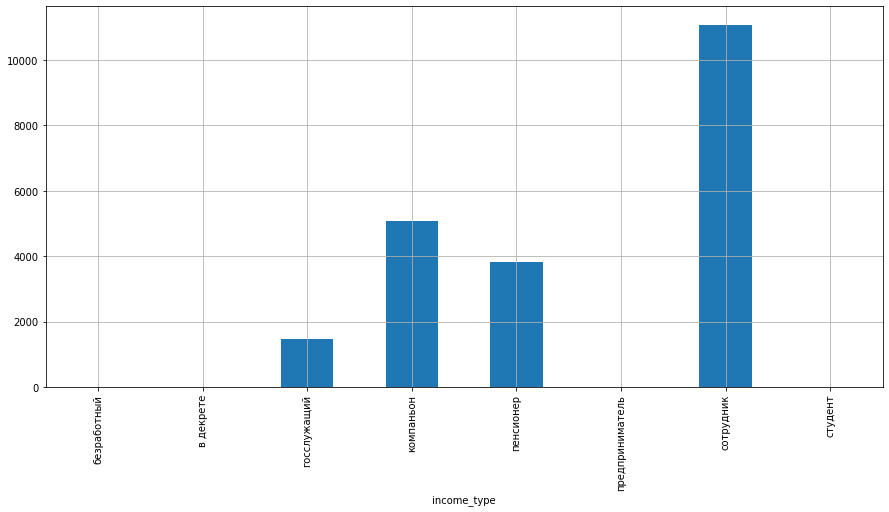

In [45]:
df.groupby('income_type')['income_type'].count().plot(kind = 'bar', grid = True, figsize = (15,7))

In [46]:
df['education'].value_counts()

среднее                15172
высшее                  5250
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [47]:
df['total_income'].mean()

165319.57229421087

In [48]:
df['debt'].mean()

0.08115036822970076

Среднестатистический клиент банка:
- женщина
- без детей
- замужем
- 42 года
- сотрудник
- среднее образование
- среднемесячный доход 165 тыс.руб. 
- цель кредита - недвижимость
- с 8ми процентной вероятностью она не погасит кредит в срок.

### Итог

Dыделим основные маркеры, которые напрямую вляиют на вероятность возврата кредита, а следовательно и на решение о выдаче кредита.

Факторы, положительно влияющие на выдачу кредита:
- отсутствие детей
- клиенты имеющие опыт в браке 
- клиенты со среднемесячным доходом 195820 руб
- цель кредита - недвижимость

Факторы, отрицательно влияющие на выдачу кредита:
- наличие детей
- клиенты без опыта в браке 
- клиенты со среднемесячным доходом от 107623 руб до 142594 руб.
- цель кредита - образование или автомобиль

